# 1. Introduction

In a globalized world, It is very common for a company to transfer an employee to another city or even country, offering better career prospects or salary increase. Or someone could find a better job in other company in other city. No matter the reasons, moving to other city is always very stressful, and people are afraid about not get used with the new city . The problem is worse when the person is married with children. To minimize the problems, it is better to move a place similar to his last location, with compatible venues, like schools, restaurants, swimming pools, gyms, coffee-shops, supermarkets, etc. To help people in this situation, the goal of this project is to develop a system to find out which neighborhoods are similar to the current location. We will simulate a situation where a person is moving from New York to Toronto.

# 2. Data Preparation
## 2.1 New York City Data

New York city Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web and here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572.
New York data can be downloaded from this [link](https://cocl.us/new_york_dataset). This data would be *json* format and it can be transformed into *pandas dataframe*.

Importing the libraries

In [1]:
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
import folium 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib_venn import venn2
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

Let's take a quick look at the data.

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
# relevant information is in 'features' key
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Tranform the data into a *pandas* dataframe

In [3]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
#Quick examine the head
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of New York City.

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## 2.2 Toronto City Data

Unlike New York, the neighborhood data is not readily available on the internet. So we need to use a notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.We have to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the New York dataset.
There are some rows where “Not assigned” is written. Drop the rows where borough is “Not assigned” (only). If Neighbouthood is 'Not assigned' but Borough is assigned then make corresponding Borough as Neighbourhood. Merge the rows if Postal Code and Borough of two or more rows same and merged neighbourhood will be separated by comma “,”.  Latitude and longitude information can be downloaded from [here](https://cocl.us/Geospatial_data). Finally this data and Toronto data can be merged together. 
Once both data are ready we’ll use Foursquare API to get the venues near each neighbourhood. To get the nearby venues data we must have Foursquare account and app which will give the credentials.


In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['Postcode', 'Borough', 'Neighborhood']
data = dict({key:[]*len(columns) for key in columns})

for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)
        
toronto_df = pd.DataFrame.from_dict(data=data)[columns]
print("Before dropping the 'Not assigned' rows, shape is: ",toronto_df.shape)

toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop = True)
print('After dropping rows where borough is "Not assigned", Shape is: ',toronto_df.shape)
print('Number of rows where Neighborhood is "Not assigned" but borough has value: ', 
      toronto_df[toronto_df['Neighborhood'] == 'Not assigned'].shape[0])

# making corresponding Borough as Neighbourhood: where Neighbourhood is 'Not assigend'
p, b, n = [], [], []
for postcode, borough, neigh in zip(toronto_df['Postcode'], toronto_df['Borough'], toronto_df['Neighborhood']):
    p.append(postcode)
    b.append(borough)
    if neigh == 'Not assigned':
        n.append(borough)
    else:
        n.append(neigh)

toronto_df = pd.DataFrame({'Postcode': p, 'Borough': b, 'Neighborhood':n})[columns]

#merging the rows, where Postal Code and Borough is same and Neighbourhoods will be seperated by ','
# :https://stackoverflow.com/a/27298308
toronto_df = toronto_df.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()
print('Before Adding the latitude and longitue, shape is: ',toronto_df.shape)



Before dropping the 'Not assigned' rows, shape is:  (180, 3)
After dropping rows where borough is "Not assigned", Shape is:  (103, 3)
Number of rows where Neighborhood is "Not assigned" but borough has value:  0
Before Adding the latitude and longitue, shape is:  (103, 3)


In [8]:
toronto_df

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,Malvern / Rouge
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,Scarborough,Guildwood / Morningside / West Hill
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West
9,M1N,Scarborough,Birch Cliff / Cliffside West


Create two columns

In [9]:
toronto_df['Latitude'] = np.nan
toronto_df['Longitude'] = np.nan
toronto_df

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,NaN,NaN
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,NaN,NaN
2,M1E,Scarborough,Guildwood / Morningside / West Hill,NaN,NaN
3,M1G,Scarborough,Woburn,NaN,NaN
4,M1H,Scarborough,Cedarbrae,NaN,NaN
5,M1J,Scarborough,Scarborough Village,NaN,NaN
6,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,NaN,NaN
7,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,NaN,NaN
8,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,NaN,NaN
9,M1N,Scarborough,Birch Cliff / Cliffside West,NaN,NaN


Geocode isn't working! So I am using pgeocode. 
I prefered to do this instead of loading the file http://cocl.us/Geospatial_data

In [10]:
pip install pgeocode

Note: you may need to restart the kernel to use updated packages.


Geocode is working, but it acept only the postcode in the query string.

In [10]:
import pgeocode
nomi = pgeocode.Nominatim('ca')
lats=[]
longs=[]
for i, row in toronto_df.iterrows():
    code = row['Postcode']
    location = nomi.query_postal_code(code)
    lats.append(location.latitude)
    longs.append(location.longitude)
toronto_df['Latitude']=lats
toronto_df['Longitude']=longs
toronto_df.tail(20)

,Postcode,Borough,Neighborhood,Latitude,Longitude
83,M6R,West Toronto,Parkdale / Roncesvalles,43.6469,-79.4521
84,M6S,West Toronto,Runnymede / Swansea,43.6512,-79.4828
85,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.6641,-79.3889
86,M7R,Mississauga,Canada Post Gateway Processing Centre,NaN,NaN
87,M7Y,East Toronto,Business reply mail Processing CentrE,43.7804,-79.2505
88,M8V,Etobicoke,New Toronto / Mimico South / Humber Bay Shores,43.6075,-79.5013
89,M8W,Etobicoke,Alderwood / Long Branch,43.6021,-79.5402
90,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.6518,-79.5076
91,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.6325,-79.4939
92,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...,43.6256,-79.5231


geocode failed to find the M7R coordinates. So, I got the coordinates from Google and inserted in the table

In [11]:
toronto_df.at[86,'Latitude'] = 43.6370
toronto_df.at[86,'Longitude'] = -79.6158
toronto_df.tail(20)

,Postcode,Borough,Neighborhood,Latitude,Longitude
83,M6R,West Toronto,Parkdale / Roncesvalles,43.6469,-79.4521
84,M6S,West Toronto,Runnymede / Swansea,43.6512,-79.4828
85,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.6641,-79.3889
86,M7R,Mississauga,Canada Post Gateway Processing Centre,43.6370,-79.6158
87,M7Y,East Toronto,Business reply mail Processing CentrE,43.7804,-79.2505
88,M8V,Etobicoke,New Toronto / Mimico South / Humber Bay Shores,43.6075,-79.5013
89,M8W,Etobicoke,Alderwood / Long Branch,43.6021,-79.5402
90,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North,43.6518,-79.5076
91,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...,43.6325,-79.4939
92,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...,43.6256,-79.5231


Save the dataset

In [12]:
#Save dataset to .csv 
toronto_df.to_csv('Toronto_2.csv')

In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


Getting the Toronto's coordinates to center the map to show the boroughs

In [14]:
address = 'Toronto, Ontario, CN'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6425012, -79.3871153.


In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], 
                                           toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 2.3 Using Foursquare to Get Venue Data

Foursquare was used to get venues informations from each neighborhood. First, it has been necessary to obtain the client ID and the secret to get access to the online API. 
The procedures bellow were used to get the venues data.

In [16]:
CLIENT_ID = 'EYTA5NXDL1UUYLI1TXNWTP5NZTQHT32V22UXFJ5TZ5HIKZGG' # your Foursquare ID
CLIENT_SECRET = 'YZUHQIXNXAK3H0L3QXPSPDUJ11QF0RI3ROXK112ABODLUBIX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: EYTA5NXDL1UUYLI1TXNWTP5NZTQHT32V22UXFJ5TZ5HIKZGG
CLIENT_SECRET:YZUHQIXNXAK3H0L3QXPSPDUJ11QF0RI3ROXK112ABODLUBIX


In [17]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    
        print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [18]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighborhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighborhood'] = venues['Neighborhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighborhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighborhood', how = 'left')
    
    return onehot_coded_df

In [19]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

### 2.3.1 New York Venues data

In [20]:
try:
    df1 = pd.read_csv('New_York_venue.csv')
except:
    df1 = return_venues_for_boroughs(ny_df)
    df1.fillna(0,  inplace = True)
    df1.to_csv('New_York_venue.csv',  index_label = False)
print('Shape data is: ', df1.shape)
df1.head()

Shape data is:  (306, 481)


,Borough,Neighborhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Hockey Rink,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Sh

### 2.3.2 Toronto Venues Data

In [21]:
try:
    df2 = pd.read_csv('Toronto_venue.csv')
except:
    df2 = return_venues_for_boroughs(toronto_df)
    df2.fillna(0, inplace = True)
    df2.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape data is: ', df2.shape)
df2.head()

Shape data is:  (103, 348)


,Postcode,Borough,Neighborhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Plac

# 3. Data Analysis

New York and Toronto dataset are very similar, but some columns are diferent. Let's analyze how many venue categories are common in both cities dataset.

In [22]:
common = 0
diff_in_NY = 0

for i in df1.columns[5:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       :{}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))


Number of common venue categories in both data are       :312
Number of different venue categories in New York city are: 164
Number of different venue catehories in Toronto city are : 31


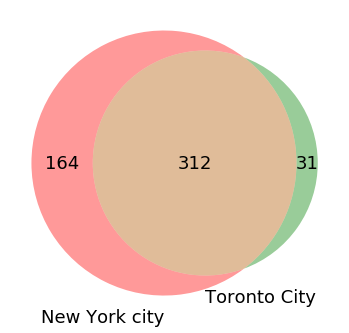

In [23]:
cl1 = set(df1.columns[5:])
cl2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['New York city', 'Toronto City'])
# chnage the text size of matplotlib venn:https://stackoverflow.com/a/29426251
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

As we have 312 common categories, we will use only these categories to compare the venues of both cities.

In [24]:
comm_col = []
for i in df1.columns[5:]:
    if i in df2.columns[5:]:
        comm_col.append(i)

col1 = list(df1.columns[0:4]) + comm_col
col2 = list(df2.columns[0:5]) + comm_col
print('Before removing non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('After removing non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))

Before removing non-common shape of New York: (306, 481), and shape of Toronto is: (103, 348)
After removing non-common shape of New York: (306, 316), and shape of Toronto is: (103, 317)


# 4. Finding Most Similar Location in other City

To find the most similar location in the other city, we will use cosine similarity.


In [25]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [41]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    
    print(current_borough)
    print(current_neigh)
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough) 
                        & (df1['Neighborhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough) 
                & (df2['Neighborhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[aa, :]
    else:
        my_borough = df1.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = label1, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighborhood'], c):
        print('\n Neighborhood: ', label)
        label = folium.Popup(label, parse_html=True)        
        folium.CircleMarker([lat, lng], radius = 5, popup=label, color='blue', 
                      tooltip = priority, parse_html=False).add_to(my_map)  

    return my_map

## 4.1 Moving from Wingate, Brooklyn, to Toronto

In [42]:
most_similar_borough(current_city = 'New York', current_borough = 'Brooklyn',
                     current_neigh = 'Wingate', n_most_similar = 5)

Brooklyn
Wingate

 Neighborhood:  South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens

 Neighborhood:  Steeles West / L'Amoreaux West

 Neighborhood:  Milliken / Agincourt North / Steeles East / L'Amoreaux East

 Neighborhood:  Clarks Corners / Tam O'Shanter / Sullivan

 Neighborhood:  Woburn


## 4.1 Moving from Woburn, Scarborough, to New York

In [43]:
most_similar_borough(current_city = 'Toronto', current_borough = 'Scarborough',
                     current_neigh = 'Woburn', n_most_similar = 5)

Scarborough
Woburn

 Neighborhood:  Clason Point

 Neighborhood:  Prince's Bay

 Neighborhood:  Bayswater

 Neighborhood:  Bellaire

 Neighborhood:  Arden Heights
